# Tutorial: Semantic Semantic Segmentation

**This guide compares a fine-tuned [SegFormer](https://arxiv.org/abs/2105.15203) with a fine-tuned variant of the 'The devil is in the labels' paper from [Yin et al.](https://arxiv.org/abs/2202.02002) on a semantic segmentation task. The dataset used is the [CMP Facade Database](https://cmp.felk.cvut.cz/~tylecr1/facade/).**

The main framework we will utilize is Huggingface [`🤗 transformers`](https://huggingface.co/transformers), an open-source library that offers easy-to-use implementations of state-of-the-art models. Baseline models are made publicly available on the HuggingFace hub, the largest open-source catalog of models and datasets, which includes the used Segformer baseline.

**Semantic segmentation** is the task of classifying each pixel in an image to a corresponding category. It has a wide range of use cases in fields such as medical imaging, autonomous driving, robotics, etc. For the facade dataset we are interested to classify the front-view of buildings based on 12 distinct classes. The classes are as follows: facade, molding, cornice, pillar, window, door, sill, blind, balcony, shop, deco, and background. 

In 2014, [Long et al.](https://arxiv.org/abs/1411.4038) published a fundamental paper that used convolutional neural networks for semantic segmentation. More recent successes in computer vision include the usage of Transformers, therefore also the usage in image classification tasks (i.e. [ViT](https://huggingface.co/blog/fine-tune-vit)). In this turn, Transformers have also been used for semantic segmentation, demonstrating excellent performance on several widely used datasets. We will specifically look at the SegFormer, which is a state-of-the-art model architecture for semantic segmentation introduced in 2021. It has a hierarchical Transformer encoder that does not rely on positional encodings and a simple multi-layer perceptron decoder.  In this case, we will use SegFormer to classify street view images of buildings.

More, recently, Yin et al. introduced a novel approach to semantic segmentation that achieves state-of-the-art performance in a zero-shot setting. This means that the model is able to achieve results equivalent to supervised methods on various semantic segmentation datasets, without being trained on these datasets. The approach involves replacing class labels with vector-valued embeddings of short paragraphs that describe the class. This allows for the merging of multiple datasets with different class labels and semantics, resulting in a merged dataset of over 2 million images. The resulting model achieves performance equal to state-of-the-art supervised methods on 7 benchmark datasets, and even outperforms methods when fine-tuned on standard semantic segmentation datasets. 

See the following illustration taken from their paper (`The devil is in the labels: Semantic segmentation from sentences` ([Yin et al.](https://arxiv.org/abs/2202.02002))):

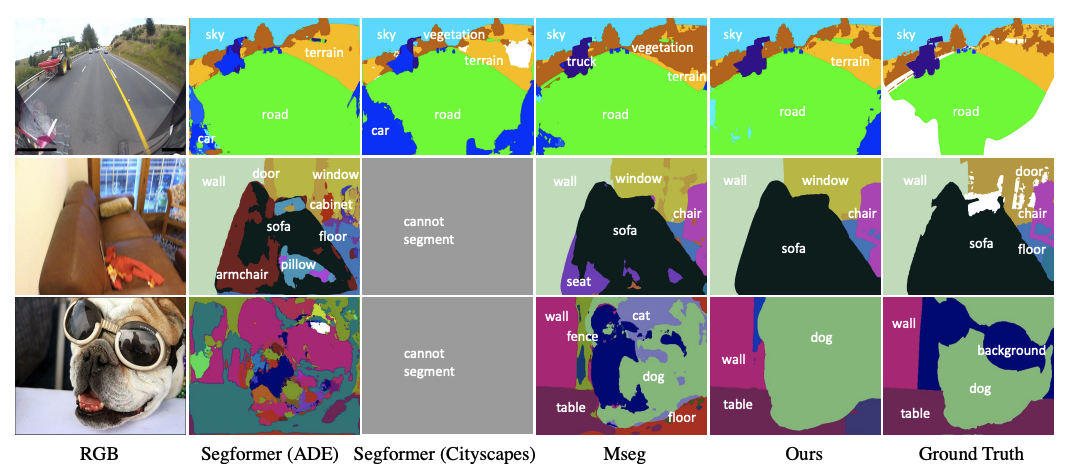

Therefore, we will specifically look at this aspect and use their pre-traind encoder backbone (based on the B5 - largest variant - since the authors only checkpoints available for this version) and fine-tune a decoder head for the CMP facade dataset, which has only very few labeled examples (<400). We will then put this model into perspective with a more approachable, smaller version of a default SegFormer B0 model. 

This tutorial was base on the [fine-tuning blog post](https://huggingface.co/blog/fine-tune-segformer) from HuggingFace. The main aspect of this tutorial will be how can we use a custom dataset and custom pre-trained models to push them to HuggingFace. 
We will look at HuggingFace because we want to make our models as accessible as possible for the community. 

At the end we will then have a more scientific disscussion about their paper and potential improvements. 

----

Let's start by logging in to HuggingFace.

In [1]:
# ignore unnecessary warning
from huggingface_hub import notebook_login
import warnings
warnings.filterwarnings("ignore")


hf_username = "Xpitfire"
notebook_login()


Login successful
Your token has been saved to /home/ubuntu/.huggingface/token


# 1. Load a dataset

In order to train a semantic segmentation model, we need a dataset with semantic segmentation labels. One option is to use the `CMP Facade Database`, which is specifically designed for semantic segmentation tasks. The [original dataset](https://cmp.felk.cvut.cz/~tylecr1/facade/) has been specifically adjusted to work with the HuggingFace `Dataset` format. For that purpose, there is a dedicated [script](datasets/load_cmp.py) in the `datasets` folder that creates a PyTorch Dataset and then coverts it to a HuggingFace and pushes the data to the Hub.  

Next, we can now also use the CMPDataset class and get some meta-data about label names and their respective mappings to IDs.

In [25]:
import numpy as np
from copy import deepcopy
from dataset.load_cmp import CMPDataset

# helper variables for ids and labels
id2label = CMPDataset.id2label
label2id = {v: k for k, v in id2label.items()}
unique_colors = CMPDataset.unique_colors
num_labels = CMPDataset.num_labels


From the HuggingFace Hub now have access to the CMP Facade Dataset and can simply download it in one line. The nice thing is that the `load_dataset` function returns already a `train`, `eval` and `test` split. The `eval` and `test` split are actually obtained by splitting the original CMP Facade `Extended dataset` in half. Overall, giving us 378 samples for training, 114 samples for validation and 114 samples for testing.

In [2]:
from datasets import load_dataset
ds = load_dataset('Xpitfire/cmp_facade')

train_ds = ds['train']
eval_ds = ds['eval']
test_ds = ds['test']


Using custom data configuration Xpitfire--cmp_facade-642b435710aeac91
Reusing dataset parquet (/home/ubuntu/.cache/huggingface/datasets/Xpitfire___parquet/Xpitfire--cmp_facade-642b435710aeac91/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

## Feature extractor & data augmentation

A SegFormer model expects the input to be of a certain shape. To transform our training data to match the expected shape, we can use `SegFormerFeatureExtractor`. Furthermore, we'll use dedicated `transform` functions, which will prepare augmented batches of data when that data is needed (on-the-fly). This way, we can start training without waiting for further data preprocessing. However, at the cost of slower iterations per batch. Nethertheless, this should be not a problem, since we have anyways a very limited dataset and neet to care about not overfitting than speedup.

In our transform, we define augmentations to make our model more resilient to different lighting conditions, and building views by randomly cropping the images plus horizontal flipping. We use the [`ColorJitter`](https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html), [`RandomResizedCrop`](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomResizedCrop.html) and [RandomHorizontalFlip](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomHorizontalFlip.html) functions from `torchvision` to randomly change the brightness, contrast, saturation, hue and viewport position of the images in the batch. We could also use further augmentation methods, such as rotations, etc. but we are good so far.

In [27]:
import torch
import torchvision.transforms as T
from transformers import SegformerFeatureExtractor

feature_extractor = SegformerFeatureExtractor()
jitter = T.ColorJitter(brightness=0.25, contrast=0.25,
                       saturation=0.25, hue=0.1)
crop = T.RandomResizedCrop(512)
flip = T.RandomHorizontalFlip(0.5)


def train_transforms(example_batch):
    # color jettering
    images = [jitter(x) for x in example_batch['pixel_values']]

    # random crop
    iamges = [i for i in images]
    labels = [x for x in example_batch['label']]
    # get features and normalization
    inputs = feature_extractor(images, labels)

    # perform random cropping and flipping
    for i in range(len(inputs['pixel_values'])):
        # concatenate images
        image = torch.from_numpy(inputs['pixel_values'][i])
        target = torch.from_numpy(inputs['labels'][i]).view(
            1, *image.shape[1:]).expand_as(image)
        both_images = torch.cat((image.unsqueeze(0), target.unsqueeze(0)), 0)
        # Apply the transformations to both images simultaneously:
        transformed_images = crop(both_images)
        transformed_images = flip(both_images)
        # Get the transformed images:
        inputs['pixel_values'][i] = transformed_images[0].numpy()
        inputs['labels'][i] = transformed_images[1][0].to(torch.int64).numpy()
    return inputs


def val_transforms(example_batch):
    # do not perform any augmentation here
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
eval_ds.set_transform(val_transforms)
# copy this to also have a version to show without transformations
test_ds_ori = deepcopy(test_ds)
test_ds.set_transform(val_transforms)


### Visualizing our Data

Now we will first look into our data and display an image with the corresponding segemtnation mask overlayed using `matplotlib`. The function is then called with an image and mask from `cmp_ds_train` Dataset and the resulting image is displayed.

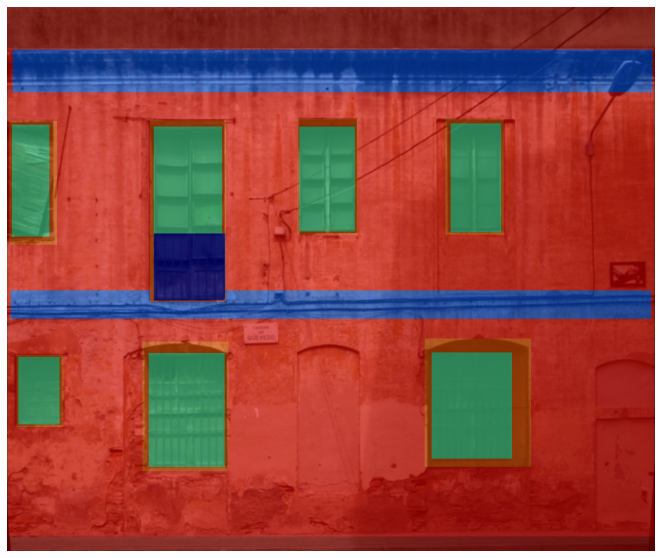

In [44]:
import matplotlib.pyplot as plt


def visualize_seg_mask(image: np.ndarray, mask: np.ndarray):
    color_seg = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    palette = np.array(unique_colors)
    for label, color in enumerate(palette):
        color_seg[mask == label, :] = color
    color_seg = color_seg[..., ::-1]  # convert to BGR

    # plot the image with the segmentation map
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.show()


# visualize the image + segmentation mask
visualize_seg_mask(
    np.array(test_ds_ori[0]['pixel_values']),
    np.array(test_ds_ori[0]['label'])
)


# 3. Fine-tune a Model

This step now already considers the fine-tuning of our pre-trained models. For the Yin et al. model we will first load their respective checkpoint to obtain their pre-trained encoder and then write a custom `SegformerForSemanticSegmentation` class which re-uses our encoder and adds a decoder on top. This is then also the common interface of both fine-tuned models (baseline and the custom model) and allows us to re-use training loops and configurations from HuggingFace. 

## Prepare and load the model to fine-tune

The SegFormer authors define 5 models with increasing sizes: B0, B1, ..., B5. Yin et al. also provides pre-trained checkpoints in their repo, however, only for the B5 version of the SegFormer (see [Repository Link](https://github.com/irfanICMLL/SSIW/tree/master)).
In this notebook, we'll provide code to load the smallest SegFormer model (B0), pre-trained on ImageNet-1k, which is all together only ~50MB in size, and code to load the pre-trained SegFromer model (B5) from Yin et al. which is a 1GB monster in comparison. Both options are shown below:

### [Option 1]: SegFormer (B5) from Yin et al.

The following loading code excludes weights taht are specifc to the decoder of the original tasks.

In [21]:
import torch
from utils.segformer import get_configured_segformer

seg_model = get_configured_segformer(
    num_labels, criterion=None, load_imagenet_model=False)
seg_model.eval()
seg_model = torch.nn.DataParallel(seg_model)
ckpt_path = 'models/segformer_7data.pth'
checkpoint = torch.load(ckpt_path, map_location='cpu')['state_dict']
# exclude weights that are not used and cannot be tune for our task
ckpt_filter = {k: v for k, v in checkpoint.items(
) if 'criterion.0.criterion.weight' not in k}
ckpt_filter = {k: v for k, v in ckpt_filter.items(
) if 'module.segmodel.head' not in k}
ckpt_filter = {k: v for k, v in ckpt_filter.items(
) if 'module.segmodel.auxi_net' not in k}
seg_model.load_state_dict(ckpt_filter, strict=False)


Now, we create a class that takes in a segmentation encoder and adds a decoder head which we will fine-tune. We will not fine-tune on all parameters (because of computaional limitations), but only on the decoder.

The following code defines a custom PyTorch model for semantic segmentation, which is a subtype of image segmentation where each pixel in an image is classified into one of several predefined classes. The custom model is called `CustomSegformerForSemanticSegmentation` and it is based on the `Segformer` model from the `transformers` library. 

In the `__init__` function, the custom model takes in a configuration object (`config`) and a pre-trained `Segformer` model (`seg_model`). It initializes the parent `SegformerPreTrainedModel` class and then assigns the `seg_model` to an attribute called `segformer` and creates an instance of `SegformerDecodeHead` with the same `config` object. 

The `forward` method takes in several inputs, including pixel values for the image, labels for the image, and optional arguments for whether to output attentions and hidden states. The `segformer` attribute is then used to process the pixel values, and the output is passed through the `decode_head` to produce logits. 

If labels are provided, the logits are upsampled to the original size of the image using bilinear interpolation, and a loss function (`CrossEntropyLoss`) is used to calculate the loss between the upsampled logits and the labels. The loss, logits, and hidden states (which are set to `None`) are returned in a `SemanticSegmenterOutput` object. 

At the end of the code, a `SegformerConfig` object is created with the given parameters, and a instance of the `CustomSegformerForSemanticSegmentation` model is created with that `config` and passed `seg_model.encoder` and then `cuda()` is called to move the model to GPU.

In [22]:
from typing import Optional, Union, Tuple
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from transformers import SegformerPreTrainedModel, SegformerConfig, SegformerDecodeHead
from transformers.modeling_outputs import SemanticSegmenterOutput


class CustomSegformerForSemanticSegmentation(SegformerPreTrainedModel):
    def __init__(self, config, seg_model):
        super().__init__(config)
        self.segformer = seg_model
        self.decode_head = SegformerDecodeHead(config)

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        pixel_values: torch.FloatTensor,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SemanticSegmenterOutput]:
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )

        outputs = self.segformer(
            pixel_values,
        )
        logits = self.decode_head(outputs)

        loss = None
        if labels is not None:
            if not self.config.num_labels > 1:
                raise ValueError(
                    "The number of labels should be greater than one")
            else:
                # upsample logits to the images' original size
                upsampled_logits = nn.functional.interpolate(
                    logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
                )
                loss_fct = CrossEntropyLoss(
                    ignore_index=self.config.semantic_loss_ignore_index)
                loss = loss_fct(upsampled_logits, labels)

        return SemanticSegmenterOutput(
            loss=loss,
            logits=logits,
            hidden_states=None,
            attentions=None,
        )


configuration = SegformerConfig(subnorm_type='batch',
                                semantic_loss_ignore_index=0,
                                hidden_sizes=[64, 128, 320, 512],
                                decoder_hidden_size=768,
                                num_labels=num_labels)
model = CustomSegformerForSemanticSegmentation(configuration,
                                               seg_model.module.segmodel.encoder).cuda()


### [Option 2]: SegFormer (B0) Baseline

This will be our baseline model to which we compare. Here we use the SegFormer from the HuggingFace Hub.

In [120]:
from transformers import SegformerForSemanticSegmentation

pretrained_model_name = "nvidia/mit-b0"
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)
model = model.cuda()


Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.running_var', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.classifier.weight', 'decode_head.batch_norm.running_mean', 'decode_head.line

## Configuring and running the Trainer

To fine-tune the model on our data, we'll use HuggingFace's [Trainer API](https://huggingface.co/docs/transformers/main_classes/trainer). The trainer requires a configuration object and a metric which we use for evaluation.

First, we'll set up the [`TrainingArguments`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments). This defines all training hyperparameters, such as learning rate and the number of epochs, frequency to save the model and so on. We also specify to push the model to the hub after training (`push_to_hub=True`) and specify a model name (`hub_model_id`).

In [128]:
from transformers import TrainingArguments

epochs = 50
lr = 0.0006
batch_size = 12

hub_model_id = "segformer-finetuned-segments-cmp-facade"

# training configuration
training_args = TrainingArguments(
    "segformer-finetuned-segments-cmp-facade-outputs-transforms",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id=hub_model_id,
    hub_strategy="end",
    optim='adamw_torch',
    remove_unused_columns=True
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Next, we'll define a function that computes the evaluation metric we want to work with. Because we're doing semantic segmentation, we'll use the mean Intersection over Union (mIoU), directly accessible in the `datasets` library (see [here](https://huggingface.co/metrics/mean_iou)). IoU represents the overlap of segmentation masks. Mean IoU is the average of the IoU of all semantic classes. Take a look at [this blogpost](https://www.jeremyjordan.me/evaluating-image-segmentation-models/) for an overview of evaluation metrics for image segmentation.

Because our model outputs logits with dimensions $\text{height} / 4$ and $\text{width} / 4$, we have to upscale them before we can compute the mIoU.

In [129]:
import torch
import numpy as np
from torch import nn
from datasets import load_metric

metric = load_metric("mean_iou")


def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        # scale the logits to the size of the label
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(predictions=pred_labels, references=labels,
                                 num_labels=num_labels,
                                 ignore_index=0,
                                 reduce_labels=False)
        for key, value in metrics.items():
            if type(value) is np.ndarray:
                metrics[key] = value.tolist()[1:]
        return metrics


Finally, we can instantiate a `Trainer` object by passing the training configurations and metrics as parameters.

In [130]:
from transformers import Trainer


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = None
        outputs = model(**inputs)
        loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]
        return (loss, outputs) if return_outputs else loss


trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    compute_metrics=compute_metrics,
)


/publicwork/dinu/workspace/SSIW/segformer-finetuned-segments-cmp-facade-outputs-transforms is already a clone of https://huggingface.co/Xpitfire/segformer-finetuned-segments-cmp-facade. Make sure you pull the latest changes with `repo.git_pull()`.


Now that our trainer is set up, training is as simple as calling the `train` function. We don't need to worry about managing our GPU(s), the trainer will take care of that. Furthermore, the nice thing of using the HuggingFace Trainer is that if Weights&Biases (W&B) is also configured the trainer directly logs the training metrics and losses to W&B.

**Weights & Biases (W&B)** is a company that provides a platform for machine learning experimentation and collaboration. The platform allows data scientists and machine learning engineers to track and visualize their model training, compare different runs, and share their results with others.
W&B's platform includes a number of features that make it easy for teams to work together on machine learning projects. One of the main features is the ability to log and visualize various metrics, such as training and validation loss, accuracy, and other custom metrics. This allows users to easily understand how their models are performing and identify trends or patterns in their data.

Let us now start the training phase, which will run for 50 epochs depending if we use the baseline model or the larger B5 variant, we need to adjust the batchsize to 12 or 2 respectively:

In [ ]:
trainer.train()


In the collapsed jupyter notebook output we also see a preview of the current model performance as illustarated in the screenshot below:

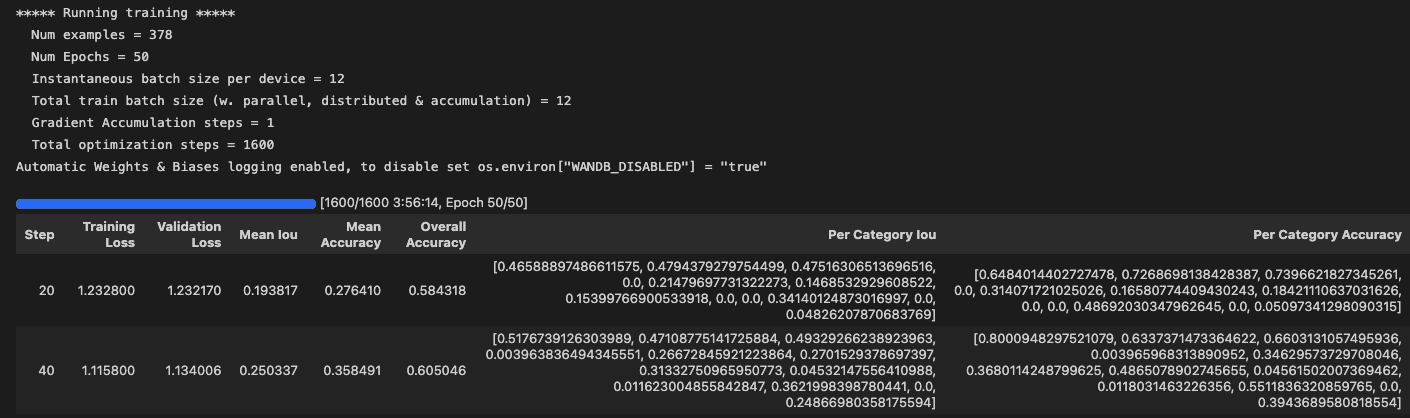

Here we will now visualize the training process and discuss a bit about what we have trained. 

The following plot shows 4 trained models. The orange model is the heavy lifter with the B5 training curve. This model took the longest and as we see although having good encoder weights, does not generalize that well on the very small dataset. However, the other three curves are the smaller B0 HuggingFace base models, which we also fine tuned. These models are much more appropraite for our task since they can achieve n only $1/3$ of training time almost double the performance. And the three varians are experiments where we look into different learning rates and where we also added the additonal data augmentation (random cropping and horizontal flipping).

**At the end of training our best performing model reached about 70% overall accuracy, which is fair for the low amount of data we have available. To see all training curves see the preview how of the generated W&B board:**

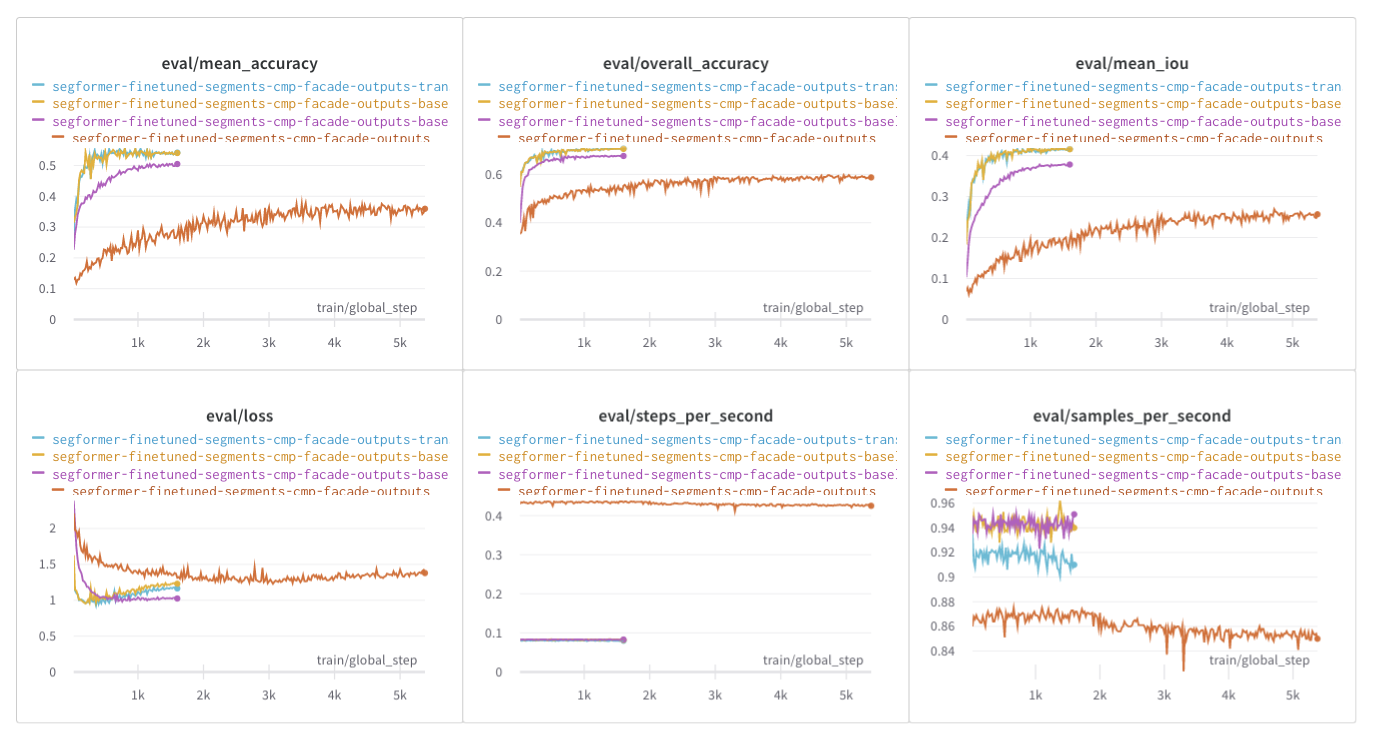

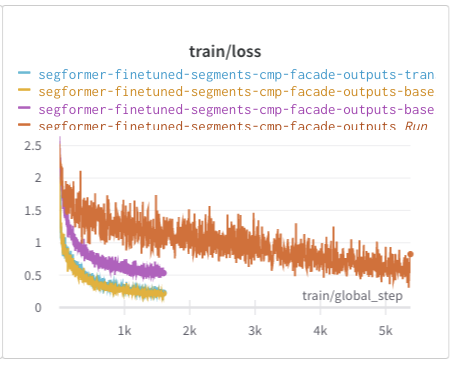

What we immediately see is that our model starts overfitting around the ~600 global training step since the eval loss goes up and if compare it with our training loss in comparison (which still goes down). All training results are made available [here](https://api.wandb.ai/report/xpitfire/oz09oyou).

When we're done with training, we can push our fine-tuned model and the feature extractor to the HuggingFace hub.

This will also automatically create a model card with our results. We'll supply some extra information in `kwargs` to make the model card more complete.

In [ ]:
hf_dataset_identifier = 'cmp-facade'

kwargs = {
    "tags": ["vision", "image-segmentation"],
    "finetuned_from": pretrained_model_name,
    "dataset": hf_dataset_identifier,
}

feature_extractor.push_to_hub(hub_model_id)
trainer.push_to_hub(**kwargs)


# 4. Visualization & Inference

Here, we'll load an image from our test dataset to verify if our training goes in the right direction. For that, we first need to prepare the image using the feature extractor. Then we forward it through the model and upscale the output logits to the original image size. In order to get the actual category predictions, we just have to apply an `argmax` on the logits.

The following code first takes an image and its corresponding ground truth segmentation from the train_ds dataset. Then it runs the image through a feature extractor function to convert the image into the proper format for the model. The output of the feature extractor function is then passed to the model, which produces logits.

Next, the logits are upsampled to the original size of the image using bilinear interpolation. Then, the argmax of the class dimension is applied to the upsampled logits to produce a predicted segmentation.

The code then defines a function `get_seg_overlay()` that takes in an image and a segmentation and returns an overlay of the image with the segmentation, where each class in the segmentation is colored with a unique color. This function is then used to create an overlay of both the predicted segmentation and the ground truth segmentation.

Finally, the code uses matplotlib to create a figure with two subplots. The first subplot shows the overlay of the predicted segmentation on the image, and the second subplot shows the overlay of the ground truth segmentation on the image. The figure is displayed on the screen, with the title for each subplot and axis turned off.

torch.Size([1, 13, 512, 512])


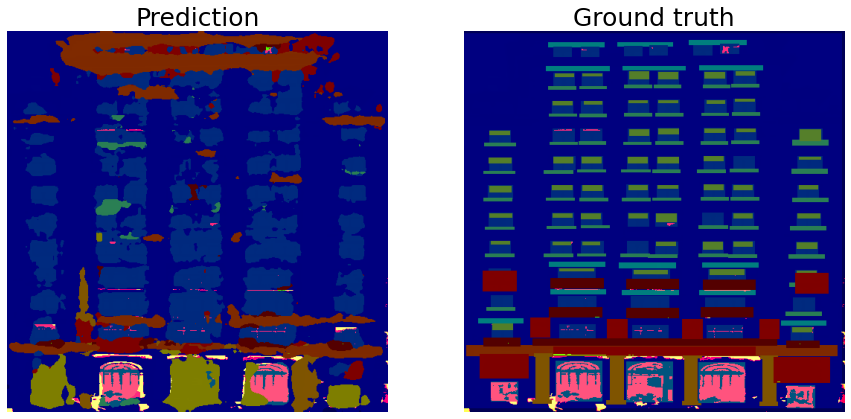

In [39]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

model = model.cpu()
img_idx = 0

image = train_ds[img_idx]['pixel_values']
gt_seg = train_ds[img_idx]['labels']

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.shape[1::],  # (height, width)
    mode='bilinear',
    align_corners=False
)
print(upsampled_logits.shape)
# Second, apply argmax on the class dimension
pred_seg = upsampled_logits.argmax(dim=1)[0]


def get_seg_overlay(image, seg):
    # height, width, 3
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
    palette = np.array(unique_colors)
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color

    # Show image + mask
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    return img


pred_img = get_seg_overlay(image.transpose(1, 2, 0), pred_seg)
gt_img = get_seg_overlay(image.transpose(1, 2, 0), np.array(gt_seg))

fig, axs = plt.subplots(1, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
plt.axis('off')
axs[0].set_title("Prediction", {'fontsize': 25})
axs[0].set_axis_off()
axs[0].imshow(pred_img)
axs[1].set_title("Ground truth", {'fontsize': 25})
axs[1].set_axis_off()
axs[1].imshow(gt_img)


The resulting mask might not be perfect yet, but let's keep training. 

### Automating the training process

A Jupyter notebook is nice, but to automate the training process and ease the search for hyper-parameters, we need to be able to run a script from command line or bash. For this purpose I created a file where you can run all the above training process by simply calling the `scripts/train.py` script. This script uses [`Hydra`](https://hydra.cc/) to handle the difference configurations and run multiple settings in parallel.  Here is an example how to call the script:

```python
python scripts/train.py --multirun lr=0.00006
```

### Deploying the Model

After training has finished, a nice way to play around with it is to use functionallities directly from the HuggingFace Hub.

There are dedicated widgets powered by the [hosted inference API](https://api-inference.huggingface.co/docs/python/html/index.html) for that purpose.
Here is the inference widget of our model on the model page. You can add default examples to the widget by defining example image URLs in your model card. See [our model card](https://huggingface.co/Xpitfire/segformer-finetuned-segments-cmp-facade) as an example.

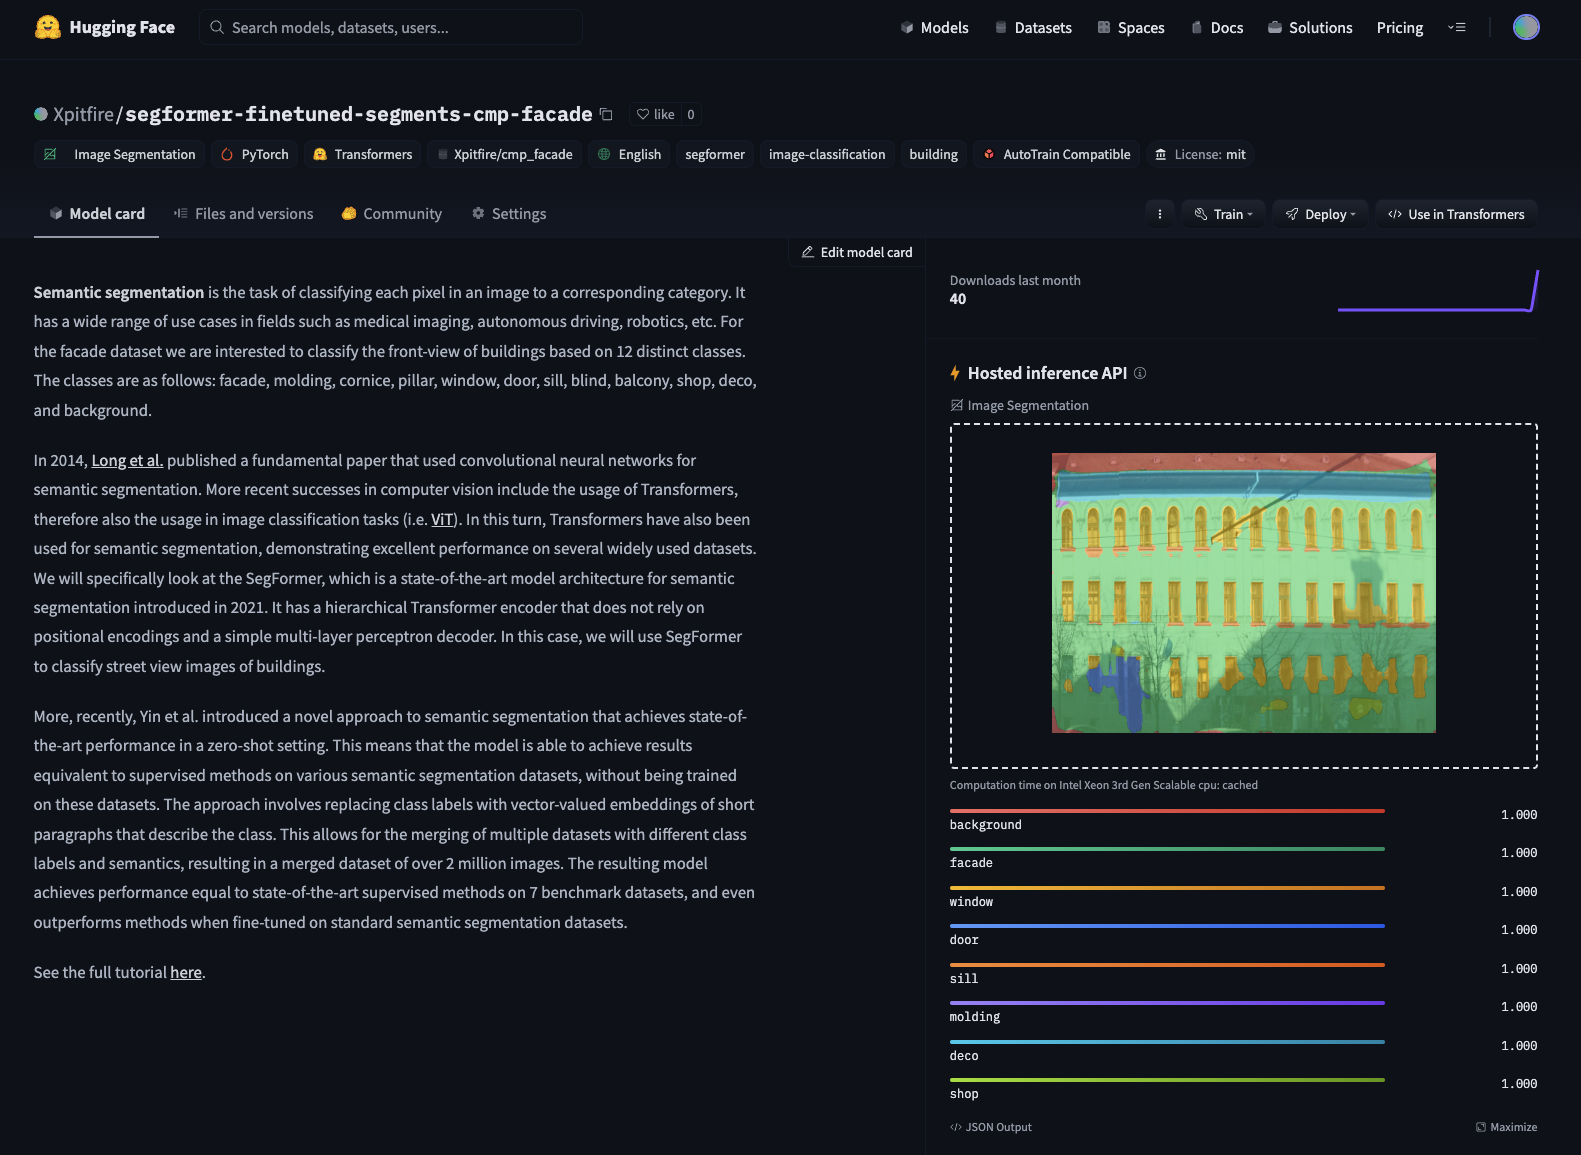

Might still not look perfect, but we can always expand our dataset to make the model more robust

## Use the model from the hub

To load our model from the hub and use it for inference we can use again the `SegformerForSemanticSegmentation.from_pretrained()` function.

In [23]:
from transformers import SegformerForSemanticSegmentation
hf_username = "Xpitfire"
hub_model_id = "segformer-finetuned-segments-cmp-facade"
model = SegformerForSemanticSegmentation.from_pretrained(
    f"{hf_username}/{hub_model_id}")


# 5. Discussions

In this section we now want to give first some engineering limitation and suggestions for improvement, but more importantly take a short detaour on a bit more scientific perspective on the paper presented by Yin et al. 

### Engineering improvements
The current implementation is still very limited. We could further improve on the hyper-paramter search, data augmentations, metrics, loss functions, etc. 
Also recently there have been many transformer-based visualization tools proposed (also for SegFormer). We could dive deeper into the vizualization topic and analyze why some of our classes do not perform that well. 
And if we really want to go towards production, we could clearly improve on the very limited dataset size with tools that help us in data labeling (i.e. see for example [Segments.ai](https://segments.ai/)).

However, for a days work with ~70% overall accuracy the results are fair and compare ok-ish to a [publication from Tyleček and Šára](https://cmp.felk.cvut.cz/~tylecr1/papers/Tylecek-GCPR2013.pdf), however, which is not the most recent paper:

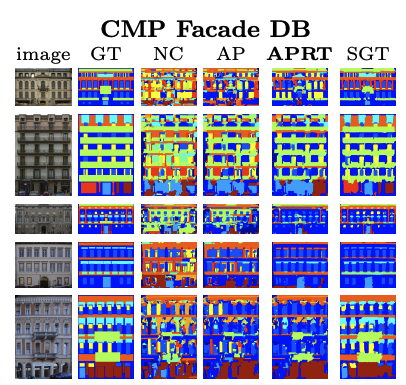

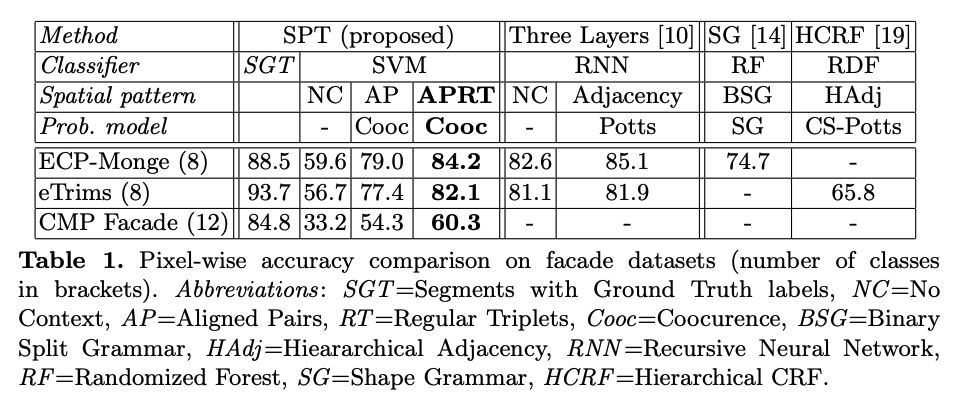

### Future Research directions
In this section we discuss some future research perspectives on the paper from Yin et al. and how we could improve their method further.

In their paper, they are encoding semantic labels into embedding vectors for a semantic segmentation model. 
They explain how labels can be encoded using a language model like CLIP-ViT, and how semantic closeness can be determined by collecting short textual descriptions from Wikipedia. 
In contrast to other work, their embeddings retain the relations among labels. 
Such relations are important for the zero-shot labels semantic segmentation.

- The main loss they use is the CLIP loss introduce [here](https://openai.com/blog/clip/). 
In it's essence, CLIP, as a foundation model for zero-shot transfer learning tasks, is pre-trained using InfoNCE and natural language supervision. 
However, it suffers from an explaining away problem. 
A more recent publication [CLOOB: Modern Hopfield Networks with InfoLOOB Outperform CLIP](https://arxiv.org/abs/2110.11316) suggests to use modern Hopfield networks to tackle this problem, however, their observations show that the CLIP loss increases the saturation effect of the InfoNCE objective.
Therefore, they introduce CLOOB, which uses modern Hopfield networks and InfoLOOB objective, to mitigate this. In their experiments, CLOOB seems to consistently outperform CLIP in terms of zero-shot transfer learning across all architectures and datasets.
Therefore, one could try to use CLOOP for receiving better zero-shot transfer performance.

- Another approach would be to further investigate the text to image embeddings of Yin et al. A recent publication [MHSAN: Multi-Head Self-Attention Network for Visual Semantic Embedding](https://openaccess.thecvf.com/content_WACV_2020/papers/Park_MHSAN_Multi-Head_Self-Attention_Network_for_Visual_Semantic_Embedding_WACV_2020_paper.pdf) looks into which is a method of expressing visual and textual data that accounts for their relationship best. 
Previous studies have used single vector representations of visual and textual data, but this paper proposes a novel multi-head self-attention network that captures various components of the data by attending to important parts. This approach has achieved new state-of-the-art results in image-text retrieval tasks such as MS-COCO and Flicker30K datasets, and can be visualized in order to demonstrate an effective and interpretable visual-semantic joint space.

- Finally, we could further investigate the triplet loss function of Yin et al. 
Having more than two loss functions is often done in practice but theoretically hard to justify, due to having multiple fix points that are optimized. 
Therefore, I would suggest to investigate to reduce the loss functions again and look into methods of unsupervised domain adaptation. 
A recent publication was [The balancing principle for parameter choice in distance-regularized domain adaptation](https://papers.nips.cc/paper/2021/file/ae0909a324fb2530e205e52d40266418-Paper.pdf) which uses the balancing principle to trade-off between source and target error, while adapting to the unlabeled target domain.
In our case, since all our data is labeled but very few samples are available, we could think of a way to perform a approach where we augment the data to create an artificial target domain and try to learn more robust embeding representation for source and "target" domains. 


# 6. Conclusion

We have shown how to create our own image segmentation dataset and how to use it to fine-tune a semantic segmentation model.
The following topics have been covered:

*   [Creating datasets](https://huggingface.co/docs/datasets/) for creating and sharing a dataset
*   [Fine-tuning SegFormer](https://huggingface.co/transformers) for easily fine-tuning a state-of-the-art baseline model and how to integraete a custom encoder model
*   `Discussions` about improvements and future research directions.
*   [HuggingFace hub](https://huggingface.co/docs/hub/main) for sharing datasets and models, and for creating an inference widget for our model


If you enjoyed this post and learned something. Feel free to share it and follow me on ([@DinuMariusC](https://twitter.com/DinuMariusC)).